In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, linear_model, tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import scipy.sparse
from sklearn.decomposition import PCA
import sklearn
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from scipy.sparse import csr_matrix
import math
import warnings
warnings.filterwarnings('ignore')
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize, RegexpTokenizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imb_pipeline

#word2vec
word2vec_model = KeyedVectors.load_word2vec_format('..\\word2vec\\roularta-320.txt')

In [2]:
filepath = '..\\Data\\'

#read data
my_data = pd.read_csv(filepath + 'input_data_model_subj.csv', quotechar='"', delimiter=',')
my_train_data = pd.read_csv(filepath + 'input_data_model_subj_train.csv', quotechar='"', delimiter=',')
my_test_data = pd.read_csv(filepath + 'input_data_model_subj_test.csv', quotechar='"', delimiter=',')

my_train_data['test'] = False
my_test_data['test'] = True
my_data = my_train_data.append(my_test_data, ignore_index = True)

#fill up NULL values in the original data with 0
my_data['fraction_total_changed_intro_original'].fillna(0, inplace=True) 
my_data['fraction_total_changed_intro_new'].fillna(0, inplace=True) 
my_data['fraction_total_changed_text_original'].fillna(0, inplace=True) 
my_data['fraction_total_changed_text_new'].fillna(0, inplace=True) 
my_data['original_changed_text'].fillna('', inplace=True) 
my_data['new_changed_text'].fillna('', inplace=True) 
my_data['topic'].fillna('other', inplace=True) 

In [3]:
#choose the appropriate learning algorithm and language model

#LEARNING ALGORITHM
#alg = 'logistic regression'
#alg = 'decision tree'
alg = 'support vector machine'

#LANGUAGE MODEL

#lang = 'no text'
lang = 'tf-idf'
#lang = 'word2vec'
#lang = 'bertje_full'
#lang = 'bertje_minimized'
#lang = 'bertje_lemmatized'
#lang = 'sbert_full'
#lang = 'sbert_minimized'
#lang = 'sbert_lemmatized'

In [4]:
#show distribution of positive and negative samples
print(my_data['type'].value_counts())

False    20785
True       344
Name: type, dtype: int64


In [5]:
#prepare the features to be inputted to the model

my_data['original_time'] = pd.to_datetime(my_data['original_time'], format='%Y-%m-%d %H:%M:%S.%f')
my_data['new_time'] = pd.to_datetime(my_data['new_time'], format='%Y-%m-%d %H:%M:%S.%f')
my_data['first_time'] = pd.to_datetime(my_data['first_time'], format='%Y-%m-%d %H:%M:%S.%f')

my_data['weekday_original'] = my_data['original_time'].dt.weekday
my_data['hour_original'] = my_data['original_time'].dt.hour
my_data['weekday_new'] = my_data['new_time'].dt.weekday
my_data['hour_new'] = my_data['new_time'].dt.hour
my_data['weekday_first'] = my_data['first_time'].dt.weekday
my_data['hour_first'] = my_data['first_time'].dt.hour

data_to_encode = my_data[['newspaper', 'topic', 'textpart', 'first_wordtype', 'last_wordtype']]
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe_data = pd.DataFrame(ohe.fit_transform(data_to_encode))

normalized_continuous_array = ['weekday_original', 'weekday_new', 'hour_original', 'hour_new',
    'length_original', 'length_new', 'max_version_number', 
                               'version_number_progress',
                                 'dates_difference', 
                               'time_difference', 'original_title_length', 'original_intro_length',
               'original_text_length', 'new_title_length', 'new_intro_length', 'new_text_length', 
                               'fraction_original_title_changed', 'fraction_new_title_changed',
              'fraction_original_intro_changed', 'fraction_new_intro_changed',
              'fraction_original_text_changed', 'fraction_new_text_changed', 
                                 'original_changed_fraction_text_part', 'new_changed_fraction_text_part', 
                'levenshtein_maximalized',
                               'nr_insert_max', 'nr_delete_max', 'nr_replace_max',
              'levenshtein_minimalized',
                               'nr_insert_min', 'nr_delete_min', 'nr_replace_min',
                               'jaccard', 'capitalized_equality',
    'seqratio', 'text_overlap_original', 'text_overlap_new',
              'stop_words_ratio',
                               'fraction_total_changed_original', 'fraction_total_changed_new',
                            'fraction_total_changed_title_original', 'fraction_total_changed_title_new',
              'fraction_total_changed_intro_original', 'fraction_total_changed_intro_new',
              'fraction_total_changed_text_original', 'fraction_total_changed_text_new',
            'ent_original', 'original_token_length', 'adv_orig', 'noun_orig', 'point_orig', 'comma_orig',
              'accent_orig', 'haakje_orig', 'doublepoint_orig', 'hyphen_orig', 'threepoints_orig', 'punct_orig', 'x_orig', 'propn_orig',
              'pron_orig', 'det_orig', 'sconj_orig', 'space_orig', 'sym_orig', 'num_orig', 'adp_orig',
              'intj_orig', 'aux_orig', 'inf_orig', 'pv_verl_ev_orig', 'pv_verl_mv_orig', 'pv_tgw_ev_orig', 'pv_tgw_mv_orig',
                'od_prenom_orig', 'od_nom_orig', 'od_postnom_orig', 'od_vrij_orig', 'vd_vrij_orig', 'vd_prenom_orig', 
              'vd_postnom_orig', 'vd_nom_orig', 'verb_orig', 'cconj_orig', 'adj_sup_orig', 'adj_comp_orig', 'adj_basis_orig',
              'ent_new', 'new_token_length', 'adv_new', 'noun_new', 'point_new', 'comma_new',
              'accent_new', 'haakje_new', 'doublepoint_new', 'hyphen_new', 'threepoints_new', 'punct_new', 'x_new', 'propn_new',
              'pron_new', 'det_new', 'sconj_new', 'space_new', 'sym_new', 'num_new', 'adp_new',
              'intj_new', 'aux_new', 'inf_new', 'pv_verl_ev_new', 'pv_verl_mv_new', 'pv_tgw_ev_new', 'pv_tgw_mv_new',
                'od_prenom_new', 'od_nom_new', 'od_postnom_new', 'od_vrij_new', 'vd_vrij_new', 'vd_prenom_new', 
              'vd_postnom_new', 'vd_nom_new', 'verb_new', 'cconj_new', 'adj_sup_new', 'adj_comp_new', 'adj_basis_new',  
              'orginal_spelling_ok', 'new_spelling_ok', 'number_comparison', 'changed_position',
                               'nr_red_parts', 'nr_green_parts', 'orig_part_of_new', 'new_part_of_orig',
                               'one_edit_change', 'sentence_sim', 'diff_sim', 
                               'doubt_words_orig', 'doubt_words_new',
                               'doubt_words_total',
                               'negation_original',
                               'negation_new', 'temporary',
              'colors', 'days', 'currencies', 'months', 'winds', 'states', 'countries', 'cities', 'belgian', 'nationality',
              'date_diff', 'person_diff', 'nr_full_sentences_original', 'nr_full_sentences_new',
                               'entity_present_in_original', 'entity_present_in_new'                          
                        ]

if lang == 'bertje_full':
    header_bertje_original = ['original_bertje_' + str(i) for i in range(0, 768)]
    header_bertje_new = ['new_bertje_' + str(i) for i in range(0, 768)]
    
if lang == 'bertje_minimized':
    header_bertje_minimized_original = ['original_minimized_bertje_' + str(i) for i in range(0, 768)]
    header_bertje_minimized_new = ['new_minimized_bertje_' + str(i) for i in range(0, 768)]

if lang == 'bertje_lemmatized':
    header_bertje_lemmatized_original = ['original_lemmatized_bertje_' + str(i) for i in range(0, 768)]
    header_bertje_lemmatized_new = ['new_lemmatized_bertje_' + str(i) for i in range(0, 768)]

if lang == 'sbert_full':
    header_sbert_original = ['original_sbert_' + str(i) for i in range(0, 512)]
    header_sbert_new = ['new_sbert_' + str(i) for i in range(0, 512)]

if lang == 'sbert_minimized':
    header_sbert_minimized_original = ['original_minimized_sbert_' + str(i) for i in range(0, 512)]
    header_sbert_minimized_new = ['new_minimized_sbert_' + str(i) for i in range(0, 512)]

if lang == 'sbert_lemmatized':
    header_sbert_lemmatized_original = ['original_lemmatized_sbert_' + str(i) for i in range(0, 512)]
    header_sbert_lemmatized_new = ['new_lemmatized_sbert_' + str(i) for i in range(0, 512)]
    
boolean_features = ['double_word', 'equal_after_subst', 'globally_equal_after_subst']
text_array_lemmatized = ['original_lemmatized_minimized_changed_text', 'new_lemmatized_minimized_changed_text']
text_array_minimized = ['original_minimized_changed_text', 'new_minimized_changed_text']
text_array_changed = ['original_changed_text', 'new_changed_text']

text_df = my_data[text_array_lemmatized].fillna('')
text_minimized_df = my_data[text_array_minimized].fillna('')
my_data = my_data.replace(np.inf, 0)

#normalize all continuous variables before continuing
normalized_continuous = (my_data[normalized_continuous_array] - my_data[normalized_continuous_array].min())/(my_data[normalized_continuous_array].max() - my_data[normalized_continuous_array].min() + 0.01)

if lang == 'bertje_full':
    normalized_bertje_original = (my_data[header_bertje_original] - my_data[header_bertje_original].min())/(my_data[header_bertje_original].max() - my_data[header_bertje_original].min() + 0.01)
    normalized_bertje_new = (my_data[header_bertje_new] - my_data[header_bertje_new].min())/(my_data[header_bertje_new].max() - my_data[header_bertje_new].min() + 0.01)

if lang == 'bertje_minimized':
    normalized_bertje_minimized_original = (my_data[header_bertje_minimized_original] - my_data[header_bertje_minimized_original].min())/(my_data[header_bertje_minimized_original].max() - my_data[header_bertje_minimized_original].min() + 0.01)
    normalized_bertje_minimized_new = (my_data[header_bertje_minimized_new] - my_data[header_bertje_minimized_new].min())/(my_data[header_bertje_minimized_new].max() - my_data[header_bertje_minimized_new].min() + 0.01)
    
if lang == 'bertje_lemmatized':
    normalized_bertje_lemmatized_original = (my_data[header_bertje_lemmatized_original] - my_data[header_bertje_lemmatized_original].min())/(my_data[header_bertje_lemmatized_original].max() - my_data[header_bertje_lemmatized_original].min() + 0.01)
    normalized_bertje_lemmatized_new = (my_data[header_bertje_lemmatized_new] - my_data[header_bertje_lemmatized_new].min())/(my_data[header_bertje_lemmatized_new].max() - my_data[header_bertje_lemmatized_new].min() + 0.01)

if lang == 'sbert_full':
    normalized_sbert_original = (my_data[header_sbert_original] - my_data[header_sbert_original].min())/(my_data[header_sbert_original].max() - my_data[header_sbert_original].min() + 0.01)
    normalized_sbert_new = (my_data[header_sbert_new] - my_data[header_sbert_new].min())/(my_data[header_sbert_new].max() - my_data[header_sbert_new].min() + 0.01)

if lang == 'sbert_minimized':
    normalized_sbert_minimized_original = (my_data[header_sbert_minimized_original] - my_data[header_sbert_minimized_original].min())/(my_data[header_sbert_minimized_original].max() - my_data[header_sbert_minimized_original].min() + 0.01)
    normalized_sbert_minimized_new = (my_data[header_sbert_minimized_new] - my_data[header_sbert_minimized_new].min())/(my_data[header_sbert_minimized_new].max() - my_data[header_sbert_minimized_new].min() + 0.01)    
    
if lang == 'sbert_lemmatized':
    normalized_sbert_lemmatized_original = (my_data[header_sbert_lemmatized_original] - my_data[header_sbert_lemmatized_original].min())/(my_data[header_sbert_lemmatized_original].max() - my_data[header_sbert_lemmatized_original].min() + 0.01)
    normalized_sbert_lemmatized_new = (my_data[header_sbert_lemmatized_new] - my_data[header_sbert_lemmatized_new].min())/(my_data[header_sbert_lemmatized_new].max() - my_data[header_sbert_lemmatized_new].min() + 0.01)
    
boolean = my_data[boolean_features]

le = preprocessing.LabelEncoder()
labels = pd.DataFrame({'labels': le.fit_transform(my_data['type'])})

test = pd.DataFrame({'test': my_data['test']})

all_data = pd.concat([ohe_data, normalized_continuous, boolean, text_minimized_df, labels, test], axis=1)

In [6]:
#adding vector embeddings in case of word2vec

if lang == 'word2vec':
    word2vec_tokenizer = TfidfVectorizer().build_tokenizer()
    
    all_data["original_tokenized"] = all_data.apply(lambda x: [word.lower() for word in word2vec_tokenizer(x['original_minimized_changed_text'])], axis=1)
    all_data["new_tokenized"] = all_data.apply(lambda x: [word.lower() for word in word2vec_tokenizer(x['new_minimized_changed_text'])], axis=1)

    all_data["original_word2vec_array"] = all_data.apply(lambda x: [word2vec_model[word] for word in x["original_tokenized"] if word in word2vec_model], axis=1)
    all_data["new_word2vec_array"] = all_data.apply(lambda x: [word2vec_model[word] for word in x["new_tokenized"] if word in word2vec_model], axis=1)

    all_data["original_word2vec"] = all_data.apply(lambda x: [float(sum(l))/len(l) for l in zip(*x["original_word2vec_array"])], axis=1)
    all_data["new_word2vec"] = all_data.apply(lambda x: [float(sum(l))/len(l) for l in zip(*x["new_word2vec_array"])], axis=1)

    original_column_names = ['original_word2vec_' + index for index in [str(i) for i in range(0, 320)]]
    new_column_names = ['new_word2vec_' + index for index in [str(i) for i in range(0, 320)]]
    word2vec_column_names = ['word2vec_' + index for index in [str(i) for i in range(0, 320)]]

    word2vec_data_original = pd.DataFrame(all_data["original_word2vec"].to_list(), columns=original_column_names)
    word2vec_data_new = pd.DataFrame(all_data["new_word2vec"].to_list(), columns=new_column_names)
    word2vec_data = pd.DataFrame(word2vec_data_original - word2vec_data_new, columns=word2vec_column_names)

In [7]:
#CHOOSE THE APPROPRIATE MODEL

if lang == 'no text':
    all_data = pd.concat([ohe_data, normalized_continuous, boolean, labels, test], axis=1)

if lang == 'tf-idf':
    all_data = pd.concat([ohe_data, normalized_continuous, text_df, boolean, labels, test], axis=1)
    
if lang == 'word2vec':
    all_data = pd.concat([ohe_data, normalized_continuous, word2vec_data_original, word2vec_data_new, boolean, labels, test], axis=1)
    all_data[original_column_names] = all_data[original_column_names].fillna(0)
    all_data[new_column_names] = all_data[new_column_names].fillna(0)
    
if lang == 'bertje_full':
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_bertje_original, normalized_bertje_new, boolean, labels, test], axis=1)

if lang == 'bertje_minimized':
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_bertje_minimized_original, normalized_bertje_minimized_new, boolean, labels, test], axis=1)    

if lang == 'bertje_lemmatized':
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_bertje_lemmatized_original, normalized_bertje_lemmatized_new, boolean, labels, test], axis=1)
    
if lang == 'sbert_full':
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_sbert_original, normalized_sbert_new, boolean, labels, test], axis=1)

if lang == 'sbert_minimized':    
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_sbert_minimized_original, normalized_sbert_minimized_new, boolean, labels, test], axis=1)    

if lang == 'sbert_lemmatized':
    all_data = pd.concat([ohe_data, normalized_continuous, normalized_sbert_lemmatized_original, normalized_sbert_lemmatized_new, boolean, labels, test], axis=1)

In [8]:
#split up the training data (80%) and the test data (20%)
train_data = all_data[all_data["test"]==False].iloc[:, :-1]
test_data = all_data[all_data["test"]==True].iloc[:, :-1]

In [9]:
#ONLY TO BE EXECUTED IN CASE OF TF-IDF

#verify number of features needed for 95% threshold using LSA

#transform textual data present in the atomic changes (in the attributes 'original_changed_text' and 'new_changed_text')
#into TF-IDF features such that we have all initial features that would be used in the model

if lang == 'tf-idf':
    vectorizer_original = TfidfVectorizer()
    vectorizer_new = TfidfVectorizer()

    column_transformer = ColumnTransformer(
        [('tfidf_original', vectorizer_original, 'original_lemmatized_minimized_changed_text'), 
        ('tfidf_new', vectorizer_new, 'new_lemmatized_minimized_changed_text')],
        remainder='passthrough')

    temp_train_data = column_transformer.fit_transform(train_data)

    truncatedsvd = TruncatedSVD(n_components=1850)
    truncatedsvd.fit(temp_train_data)

    print(truncatedsvd.explained_variance_ratio_.sum())

0.9503120440724202


In [10]:
#define f2 scorer
def fbeta_score(y_true, y_pred):
    return metrics.fbeta_score(y_true, y_pred, beta=2)

In [11]:
#divide the training data into five different folds in order to apply stratified k-fold cross validation
#for the final execution of the best model
train_data["kfold"] = -1
train_data = train_data.sample(frac=1).reset_index(drop=True)
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X = train_data, y=train_data['labels'].values)):
    train_data.loc[v_, 'kfold'] = f

In [12]:
#function that implements grid search for hyperparameter optimization by selecting the optimization algorithm
#and parameters accordingly
def grid(x_train, y_train, x_test, y_test):
    
    #Grid Search Model
    if alg == 'decision tree':
        clf = tree.DecisionTreeClassifier(random_state=0)
        
        param_grid = {"classify__criterion": ['entropy', 'gini', 'log_loss'],
        "classify__max_depth": [2,4,6,8,10,12, 14, 16, 18, 20, 22, 24, 26, 28, 30]}
    
    if alg == 'logistic regression':
        clf = linear_model.LogisticRegression(class_weight='balanced', max_iter=1000)
        
        param_grid = {"classify__C":[0.01, 0.1, 1.0], "classify__penalty":["l1", "l2", "elasticnet"],
        "classify__solver": ['newton-cg', "lbfgs", "liblinear", "sag", "saga"]}
    
    if alg == 'support vector machine':
        clf = LinearSVC(class_weight="balanced", random_state=0)
        
        param_grid = {"classify__loss": ['hinge', 'squared_hinge'],
        "classify__C":[ 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], "classify__penalty":["l1", "l2"]}
    
    sampling_strategy_o = 0.40
    
    if lang == 'tf-idf':
        pipe = imb_pipeline([
                    ('tfidf', column_transformer),
                    ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                    ('classify', clf)
            ])
        
    else:
        pipe = imb_pipeline([
                    ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                    ('classify', clf)
        ])

    
    scorer = metrics.make_scorer(fbeta_score, greater_is_better=True, needs_threshold=False)

    grid_model = model_selection.GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorer,
    refit=True,
    verbose=10,
    cv=5)
    
    grid_model.fit(x_train, y_train)
    
    print("Best score: " + str(grid_model.best_score_))
    print("Best parameter set: ")
    best_parameters = grid_model.best_estimator_.get_params()
    
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    best_model = grid_model.best_estimator_
    best_model.fit(x_train, y_train)
    preds = best_model.predict(x_test)
    
    score = metrics.fbeta_score(y_test, preds, beta=2)
    print("Test score: " + str(score))

In [13]:
#perform grid search
x_train = train_data.drop('labels', axis=1).drop('kfold', axis=1)
y_train = train_data['labels'].values

x_test = test_data.drop('labels', axis=1)
y_test = test_data['labels'].values

grid(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START classify__C=1e-05, classify__loss=hinge, classify__penalty=l1
[CV 1/5; 1/24] END classify__C=1e-05, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 2/5; 1/24] START classify__C=1e-05, classify__loss=hinge, classify__penalty=l1
[CV 2/5; 1/24] END classify__C=1e-05, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 3/5; 1/24] START classify__C=1e-05, classify__loss=hinge, classify__penalty=l1
[CV 3/5; 1/24] END classify__C=1e-05, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 4/5; 1/24] START classify__C=1e-05, classify__loss=hinge, classify__penalty=l1
[CV 4/5; 1/24] END classify__C=1e-05, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 5/5; 1/24] START classify__C=1e-05, classify__loss=hinge, classify__penalty=l1
[CV 5/5; 1/24] END classify__C=1e-05, classify__loss=hinge, classify__penal

[CV 1/5; 9/24] END classify__C=0.001, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 2/5; 9/24] START classify__C=0.001, classify__loss=hinge, classify__penalty=l1
[CV 2/5; 9/24] END classify__C=0.001, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 3/5; 9/24] START classify__C=0.001, classify__loss=hinge, classify__penalty=l1
[CV 3/5; 9/24] END classify__C=0.001, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 4/5; 9/24] START classify__C=0.001, classify__loss=hinge, classify__penalty=l1
[CV 4/5; 9/24] END classify__C=0.001, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 5/5; 9/24] START classify__C=0.001, classify__loss=hinge, classify__penalty=l1
[CV 5/5; 9/24] END classify__C=0.001, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.5s
[CV 1/5; 10/24] START classify__C=0.001, classify__loss=hinge, classify__penalty=l2
[CV 1/5; 10/24] END clas

[CV 2/5; 17/24] END classify__C=0.1, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 3/5; 17/24] START classify__C=0.1, classify__loss=hinge, classify__penalty=l1
[CV 3/5; 17/24] END classify__C=0.1, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 4/5; 17/24] START classify__C=0.1, classify__loss=hinge, classify__penalty=l1
[CV 4/5; 17/24] END classify__C=0.1, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.5s
[CV 5/5; 17/24] START classify__C=0.1, classify__loss=hinge, classify__penalty=l1
[CV 5/5; 17/24] END classify__C=0.1, classify__loss=hinge, classify__penalty=l1;, score=nan total time=   0.6s
[CV 1/5; 18/24] START classify__C=0.1, classify__loss=hinge, classify__penalty=l2
[CV 1/5; 18/24] END classify__C=0.1, classify__loss=hinge, classify__penalty=l2;, score=0.227 total time=   2.8s
[CV 2/5; 18/24] START classify__C=0.1, classify__loss=hinge, classify__penalty=l2
[CV 2/5; 18/24] END classify__C=0

In [14]:
#function for the execution of the best model that was finally obtained
def run(fold, df, clf, x_valid_total, y_valid_total, preds_total_valid):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    x_train = df_train.drop('labels', axis=1).drop('kfold', axis=1)
    y_train = df_train['labels'].values
    
    x_valid = df_valid.drop('labels', axis=1).drop('kfold', axis=1)
    y_valid = df_valid['labels'].values

    clf.fit(x_train, y_train)
    
    preds_train = clf.predict(x_train)
    preds_valid = clf.predict(x_valid)

    score_train = metrics.fbeta_score(y_train, preds_train, beta=2)
    
    score_valid = metrics.fbeta_score(y_valid, preds_valid, beta=2)
    print("Validation Fold: " + str(fold) + ": " + str(score_valid))
    
    if fold == 0:
        x_valid_total = x_valid
        y_valid_total = y_valid
        preds_total_valid = preds_valid
        
    else:
        x_valid_total = np.concatenate((x_valid_total, x_valid), axis=0)
        y_valid_total = np.concatenate((y_valid_total, y_valid), axis=None)
        preds_total_valid = np.concatenate((preds_total_valid, preds_valid), axis=None)
    
    return score_valid, x_valid_total, y_valid_total, preds_total_valid

In [15]:
#execute the best model that was found using grid search
x_valid_total = None
y_valid_total = None
preds_total = None

folds = 5
sampling_strategy_o = 0.40

if alg == 'logistic regression':
    clf = linear_model.LogisticRegression(class_weight='balanced', solver='newton-cg', C=0.1, penalty='l2')
    
if alg == 'decision tree':
    clf = tree.DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=10)
    
if alg == 'support vector machine':
    clf = svm.LinearSVC(class_weight='balanced', C=0.01, loss='squared_hinge')
    
if lang == 'tf-idf':
    pipe = imb_pipeline([
                ('tfidf', column_transformer),
                ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                ('classify', clf)
        ])
        
else:
    pipe = imb_pipeline([
                ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                ('classify', clf)
    ])

avg = 0
for i in range(0, folds):
    run_fold = run(i, train_data, pipe, x_valid_total, y_valid_total, preds_total)
    avg = avg + run_fold[0]
    x_valid_total = run_fold[1]
    y_valid_total = run_fold[2]
    preds_total = run_fold[3]
    
avg = avg/folds
print("Average fold score: " + str(avg))

Validation Fold: 0: 0.25
Validation Fold: 1: 0.21258503401360546
Validation Fold: 2: 0.1819620253164557
Validation Fold: 3: 0.22569444444444442
Validation Fold: 4: 0.17499999999999996
Average fold score: 0.2090483007549011


In [16]:
#determine score on test set and averaged out over validation and test set
x_train = train_data.drop('labels', axis=1).drop('kfold', axis=1)
y_train = train_data['labels'].values

x_test = test_data.drop('labels', axis=1)
y_test = test_data['labels'].values

pipe.fit(x_train, y_train)
preds = pipe.predict(x_test)

x_valid_total = np.concatenate((x_valid_total, x_test), axis=0)
y_valid_total = np.concatenate((y_valid_total, y_test), axis=None)
preds_total = np.concatenate((preds_total, preds), axis=None)

auc = metrics.fbeta_score(y_test, preds, beta=2)
print("Test score: " + str(auc))

Test score: 0.2464332036316472


Confusion matrix, without normalization
[[3700  457]
 [  31   38]]
Normalized confusion matrix
[[0.89006495 0.10993505]
 [0.44927536 0.55072464]]


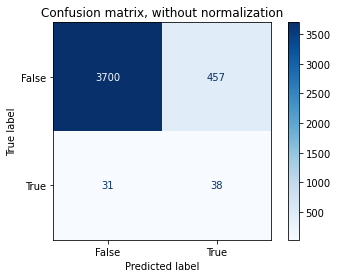

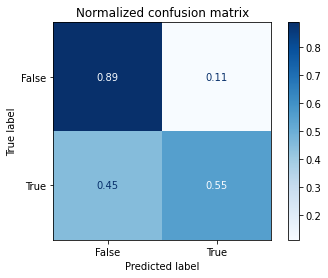

In [17]:
# Plot confusion matrix obtained by the best model
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        pipe,
        pd. DataFrame(x_test),
        y_test,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)